<a href="https://colab.research.google.com/github/oleksiyo/machine-learning-zoomcamp/blob/master/cohorts/2025/04-evaluation/Homework_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 4. Evaluation

## Data preparation
* Check if the missing values are presented in the features.
* If there are missing values:
* *   For caterogiral features, replace them with 'NA'
* *   For numerical features, replace with with 0.0

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use **train_test_split** function for that with r**andom_state=1**

In [209]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, recall_score

In [210]:
url = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv"
df_full = pd.read_csv(url)
df_full.sample(3, random_state=42)

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
892,social_media,manufacturing,2,56070.0,self_employed,middle_east,2,0.23,1
1106,NaN,other,1,78409.0,NaN,australia,4,0.79,0
413,referral,manufacturing,2,66206.0,employed,australia,3,0.30,1


In [211]:
def get_missing_values(df):
  missing_summary = (
      df_full.isnull()
        .sum()
        .reset_index()
        .rename(columns={'index': 'column_name', 0: 'missing_values'})
  )

  # Add column type
  missing_summary['dtype'] = missing_summary['column_name'].apply(lambda x: df_full[x].dtype)

  # Keep only columns that actually have missing values
  missing_summary = missing_summary[missing_summary['missing_values'] > 0]
  return missing_summary


missing_summary = get_missing_values(df_full)

# Display the result
print("Missing values summary before filling:")
display(missing_summary)

Missing values summary before filling:


,column_name,missing_values,dtype
0,lead_source,128,object
1,industry,134,object
3,annual_income,181,float64
4,employment_status,100,object
5,location,63,object


In [212]:
# List of numerical and categorical features
numerical_features = df_full.select_dtypes(include=np.number).columns.tolist()
categorical_features = df_full.select_dtypes(include="object").columns.tolist()

# Fill missing values
df_full[numerical_features] = df_full[numerical_features].fillna(0)
df_full[categorical_features] = df_full[categorical_features].fillna("NA")

In [213]:
missing_summary = get_missing_values(df_full)
print("Missing values summary before filling:")
display(missing_summary)

Missing values summary before filling:


,column_name,missing_values,dtype


In [214]:
# Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split function for that with random_state=1
# Train, Test, Validation split
full_train_df, test_df = train_test_split(df_full, test_size=0.2, random_state=1)
train_df, val_df = train_test_split(full_train_df, test_size=0.25, random_state=1)
len(train_df), len(val_df), len(test_df)

(876, 293, 293)

In [215]:
# Prepare data for modeling
target = "converted"
features = numerical_features + categorical_features
features.remove(target)

# Training set
X_train = train_df[features].reset_index(drop=True)
y_train = train_df[target].reset_index(drop=True)

# Validation set
X_val = val_df[features].reset_index(drop=True)
y_val = val_df[target].reset_index(drop=True)

# Test set
X_test = test_df[features].reset_index(drop=True)
y_test = test_df[target].reset_index(drop=True)

## Question 1: ROC AUC feature importance
ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

* For each numerical variable, use it as score (aka prediction) and compute the AUC with the `y` variable as ground truth.
* Use the training dataset for that

If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['balance']`)

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

* `lead_score`
* `number_of_courses_viewed`
* `interaction_count`
* `annual_income`

In [216]:
# Numerical values to check AUC
numerical = numerical_features.copy()
numerical.remove(target)
numerical

['number_of_courses_viewed',
 'annual_income',
 'interaction_count',
 'lead_score']

In [217]:
# Calculate AUC for each numerical feature
for feat in numerical:
    auc = roc_auc_score(y_train, X_train[feat])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -X_train[feat])
    print(f"{feat} ---> AUC: {auc:.3f}")

number_of_courses_viewed ---> AUC: 0.764
annual_income ---> AUC: 0.552
interaction_count ---> AUC: 0.738
lead_score ---> AUC: 0.614


***Answer*** : **number_of_courses_viewed**

## Question 2: Training the model
Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

`LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`

What's the AUC of this model on the validation dataset? (round to 3 digits)

* 0.32
* 0.52
* 0.72
* 0.92

In [218]:
# --- One-hot encoding using DictVectorizer ---
# Convert categorical features into numerical format (one-hot encoded)
dv = DictVectorizer(sparse=False)

# Fit the DictVectorizer on the training data and transform it
X_train = dv.fit_transform(X_train.to_dict(orient="records"))

# Transform the validation data using the same vectorizer
X_val = dv.transform(X_val.to_dict(orient="records"))

X_train.shape, X_val.shape

((876, 31), (293, 31))

In [219]:
# --- Train Logistic Regression model ---
# Create and train the model with given parameters
model = LogisticRegression(solver="liblinear", C=1.0, max_iter=1_000)
model.fit(X_train, y_train)

# --- Evaluate on validation data ---
# Get probabilities for the positive class
y_pred = model.predict_proba(X_val)[:, 1]

# Calculate the AUC (Area Under the ROC Curve)
auc = roc_auc_score(y_val, y_pred)

print(f"Validation set AUC: {auc:.3f}")

Validation set AUC: 0.817


In [220]:
# --- Choose the closest value from provided options ---
options = np.array([0.32, 0.52, 0.72, 0.92])
closest_option = options[np.abs(options - auc).argmin()]

# --- Print the final result ---
print(f"Closest answer from options: {closest_option:.3f}")

Closest answer from options: 0.720


**Answer**: **0.72**

## Question 3: Precision and Recall
Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.145
* 0.345
* 0.545
* 0.745

In [221]:
# --- Threshold range ---
# Create thresholds from 0.0 to 1.0 with a step of 0.01
thresholds = np.linspace(start=0.0, stop=1.0, num=101)

# Scores
scores = []

# --- Evaluate precision and recall for each threshold ---
for t in thresholds:
    # Convert probabilities to binary predictions using the current threshold
    y_val_binary = (y_pred >= t).astype(int)

    # Compute precision and recall for this threshold
    p = precision_score(y_val, y_val_binary, zero_division=0)
    r = recall_score(y_val, y_val_binary)

    scores.append((t, p, r))

# --- Create DataFrame with results ---
df_scores = pd.DataFrame(scores, columns=["threshold", "precision", "recall"])

# Compute absolute difference between precision and recall
df_scores["pr_diff"] = np.abs(df_scores["precision"] - df_scores["recall"])

# Find the threshold where precision and recall are closest (intersection)
intersection_threshold = (
    df_scores.query("precision != 0 & recall != 0")
    .sort_values(by="pr_diff")
    .head(1)["threshold"]
    .values[0]
)

print(f"Intersection threshold: {intersection_threshold:.3f}")

Intersection threshold: 0.640


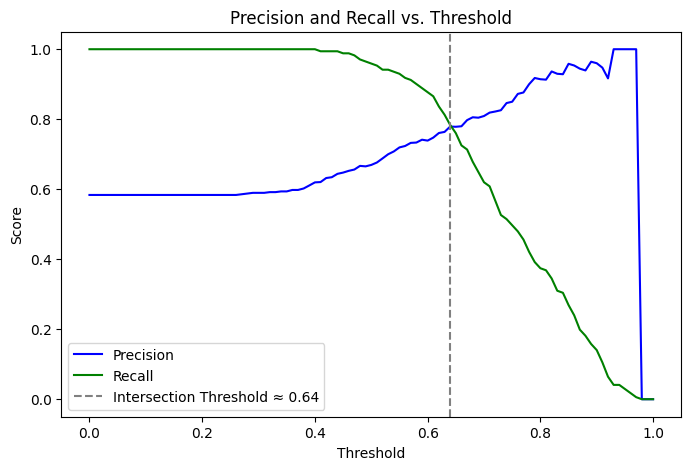

In [222]:
# --- Plot Precision and Recall curves ---
plt.figure(figsize=(8, 5))

sns.lineplot(data=df_scores, x="threshold", y="precision", label="Precision", color="blue")
sns.lineplot(data=df_scores, x="threshold", y="recall", label="Recall", color="green")

# Mark the intersection point on the plot
plt.axvline(
    x=intersection_threshold,
    color="gray",
    linestyle="--",
    label=f"Intersection Threshold ≈ {intersection_threshold:.2f}",
)

plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision and Recall vs. Threshold")
plt.legend()
plt.grid(False)
plt.show()

In [223]:
# --- Choose the closest threshold from provided options ---
options = np.array([0.145, 0.345, 0.545, 0.745])
closest_option = options[np.abs(options - intersection_threshold).argmin()]

print(f"Calculated intersection threshold: {intersection_threshold:.3f}")
print(f"Closest answer from options: {closest_option:.3f}")

Calculated intersection threshold: 0.640
Closest answer from options: 0.545


Answer: **0.545**

## Question 4: F1 score
Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

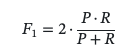

Where P is precision and R is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

* 0.14
* 0.34
* 0.54
* 0.74

In [224]:
# Compute F1 score for each threshold
df_scores["f1_score"] = 2 * (df_scores.precision * df_scores.recall) / (df_scores.precision + df_scores.recall)
df_scores["f1_score"] = df_scores["f1_score"].fillna(0)  # handle NaN where P+R=0

# Find threshold with maximum F1 score
best_f1_threshold = df_scores.loc[df_scores.f1_score.idxmax(), "threshold"]

# Match with closest provided option
options = np.array([0.14, 0.34, 0.54, 0.74])
closest_option = options[np.abs(options - best_f1_threshold).argmin()]

In [225]:
# --- Match with closest value from given options ---
options = np.array([0.14, 0.34, 0.54, 0.74])
closest_option = options[np.abs(options - best_f1_threshold).argmin()]

# --- Print results ---
print(f"Calculated best F1 threshold: {best_f1_threshold:.3f}")
print(f"Closest answer from options: {closest_option:.3f}")

Calculated best F1 threshold: 0.570
Closest answer from options: 0.540


Answer: **0.54**

## Question 5: 5-Fold CV
Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

`KFold(n_splits=5, shuffle=True, random_state=1)`

* Iterate over different folds of `[df_full_train]`
* Split the data into train and validation
* Train the model on train with these parameters:
`LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

* 0.0001
* 0.006
* 0.06
* 0.36

In [226]:
# Initialize K-Fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

auc_scores = []

# Iterate over 5 folds
for train_idx, val_idx in kfold.split(full_train_df):
    # Split into train and validation subsets
    df_train_fold = full_train_df.iloc[train_idx]
    df_val_fold = full_train_df.iloc[val_idx]

    # Extract target variable
    y_train_fold = df_train_fold[target].to_numpy()
    y_val_fold = df_val_fold[target].to_numpy()

    # One-hot encoding for features
    dv_fold = DictVectorizer(sparse=False)
    X_train_fold = dv_fold.fit_transform(df_train_fold[features].to_dict(orient="records"))
    X_val_fold = dv_fold.transform(df_val_fold[features].to_dict(orient="records"))

    # Train the Logistic Regression model
    model_fold = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model_fold.fit(X_train_fold, y_train_fold)

    # Predict probabilities and compute AUC for this fold
    y_pred_fold = model_fold.predict_proba(X_val_fold)[:, 1]
    auc = roc_auc_score(y_val_fold, y_pred_fold)
    auc_scores.append(auc)

# Calculate standard deviation across folds
std_auc = np.std(auc_scores)

# Print results
print(f"AUC scores per fold: {[round(s, 3) for s in auc_scores]}")
print(f"Standard Deviation: {std_auc:.4f}")

AUC scores per fold: [np.float64(0.806), np.float64(0.871), np.float64(0.775), np.float64(0.802), np.float64(0.856)]
Standard Deviation: 0.0358


In [227]:
# Choose closest answer from options
options = np.array([0.0001, 0.006, 0.06, 0.36])
closest_option = options[np.abs(options - std_auc).argmin()]

print(f" Closest answer from options: {closest_option:.4f}")

 Closest answer from options: 0.0600


Answer: 0.06

## Question 6: Hyperparameter Tuning
Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.000001, 0.001, 1]`
* Initialize `KFold` with the same parameters as previously
* Use these parameters for the model:
`LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

* 0.000001
* 0.001
* 1

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C.

In [228]:
# --- Hyperparameter values for regularization strength ---
C_values = [0.000001, 0.001, 1.0]

# --- Initialize 5-Fold cross-validation ---
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

results = []  # store mean and std AUC per C value

# --- Evaluate each candidate C ---
for C_value in C_values:
    fold_aucs = []

    # Go through each fold
    for train_idx, val_idx in kfold.split(full_train_df):
        # Split the dataset
        train_part = full_train_df.iloc[train_idx]
        val_part = full_train_df.iloc[val_idx]

        # Extract targets
        y_train = train_part[target].values
        y_val = val_part[target].values

        # One-hot encode categorical features
        encoder = DictVectorizer(sparse=False)
        X_train = encoder.fit_transform(train_part[features].to_dict(orient="records"))
        X_val = encoder.transform(val_part[features].to_dict(orient="records"))

        # Train logistic regression model with the current C value
        model = LogisticRegression(solver="liblinear", C=C_value, max_iter=1000)
        model.fit(X_train, y_train)

        # Predict probabilities and compute AUC
        y_pred = model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        fold_aucs.append(auc)

    # Compute statistics for this C
    mean_auc = np.mean(fold_aucs)
    std_auc = np.std(fold_aucs)
    results.append((C_value, mean_auc, std_auc))

    print(f"C={C_value:<8.6f} → mean AUC={mean_auc:.3f}, std={std_auc:.3f}")

# --- Select the best C ---
# Priority: 1) highest mean AUC, 2) lowest std, 3) smallest C
sorted_results = sorted(results, key=lambda x: (-x[1], x[2], x[0]))
best_C, best_mean, best_std = sorted_results[0]

# --- Output results ---
print(f"\n Best C: {best_C}")
print(f"Mean AUC: {best_mean:.3f} | Std: {best_std:.3f}")

C=0.000001 → mean AUC=0.560, std=0.024
C=0.001000 → mean AUC=0.867, std=0.029
C=1.000000 → mean AUC=0.822, std=0.036

 Best C: 0.001
Mean AUC: 0.867 | Std: 0.029


In [229]:
# --- Select the best C ---
# Priority: 1) highest mean AUC, 2) lowest std, 3) smallest C
sorted_results = sorted(results, key=lambda x: (-x[1], x[2], x[0]))
best_C, best_mean, best_std = sorted_results[0]

# --- Output results ---
print(f"\n Best C: {best_C}")
print(f"Mean AUC: {best_mean:.3f} | Std: {best_std:.3f}")


 Best C: 0.001
Mean AUC: 0.867 | Std: 0.029


In [230]:
# --- Match the closest option from question choices ---
options = np.array([0.000001, 0.001, 1.0])
closest_option = options[np.abs(options - best_C).argmin()]
print(f" Closest answer from options: {closest_option}")

 Closest answer from options: 0.001


Answer: 0.001